# Assignment of Model Weight to Background Datasets

This section explores assignment of model weight to different background datasets in GTEx across ~1,000 TCGA tumor samples. Despite no attempt to correct for batch effects and GTEx and TCGA being completely separate projects with different laboratory protocols, the model is able to accurately assign model weight to the appropriate tissue in GTEx for a majority of samples across ten different tumor types. 

In [10]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.decomposition import pca

sns.set(font_scale=1.0)
sns.set_style("whitegrid")


class Weights:
    def __init__(self, tumor_path: pd.DataFrame, sample_dir: str):
        self.tumor_path = tumor_path
        self.tumor = self._load_tumor()
        self.genes = self.tumor.columns[5:]
        self.sample_dir = sample_dir
        self.df = self._weight_df()
        self.tissue_perc = self._perc_df()
        self.subtype_perc = self._perc_df("subtype")
        self.num_samples = len(self.df["sample"].unique())

    def _weight_df(self) -> pd.DataFrame:
        """
        Creates DataFrame of sample weights from a directory of samples
        Columns: tissue, normal_tissue, weight, sample_id

        Returns:
            DataFrame of Weights
        """
        # DataFrame: cols=tissue, normal_tissue, weight
        weights = []
        tissues = self.tumor.tissue
        subtypes = self.tumor.subtype
        for sample in os.listdir(self.sample_dir):
            sample_tissue = tissues.loc[sample]
            sample_subtype = subtypes.loc[sample]
            w = pd.read_csv(
                os.path.join(self.sample_dir, sample, "weights.tsv"), sep="\t"
            )
            w.columns = ["normal_tissue", "Median", "std"]
            w["tissue"] = sample_tissue
            w["subtype"] = sample_subtype
            w["sample"] = sample
            # Add zero weight if missing
            if sample_tissue not in w.normal_tissue.values:
                w.loc[len(w)] = [
                    sample_tissue,
                    0,
                    0,
                    sample_tissue,
                    sample_subtype,
                    sample,
                ]
            weights.append(w.drop("std", axis=1))

        return pd.concat(weights).reset_index(drop=True)

    def _perc_df(self, group="tissue") -> pd.DataFrame:
        """
        Converts DataFrame of weights into a DataFrame of percentages

        Returns:
            Weight percentage DataFrame
        """
        c = self.df.groupby([group, "normal_tissue"])["Median"].sum().rename("count")
        perc = c / c.groupby(level=0).sum() * 100
        return perc.reset_index()

    def _load_tumor(self):
        print(f"Reading in {self.tumor_path}")
        if self.tumor_path.endswith(".csv"):
            df = pd.read_csv(self.tumor_path, index_col=0)
        elif self.tumor_path.endswith(".tsv"):
            df = pd.read_csv(self.tumor_path, sep="\t", index_col=0)
        else:
            try:
                df = pd.read_hdf(self.tumor_path)
            except Exception as e:
                print(e)
                raise RuntimeError(f"Failed to open DataFrame: {self.tumor_path}")
        return df

    def plot_match_scatter(self, out_dir: str = None):
        """
        Scatterplot of samples by tissue and their matched tissue model weight

        Args:
            out_dir: Optional output directory

        Returns:
            Plot axes object
        """
        df = self.df
        # Subset for matched-tissue samples
        df = df[df.normal_tissue == df.tissue].sort_values("tissue")

        f, ax = plt.subplots(figsize=(12, 4))
        sns.swarmplot(data=df, x="tissue", y="Median")
        plt.xticks(rotation=45)
        plt.xlabel("Tissue")
        plt.ylabel("GTEx Matched Tissue Weight")
        plt.title("TCGA Tumor Samples and Model Weight for GTEx Matched Tissue")
        if out_dir:
            plt.savefig(os.path.join(out_dir, "matched_weight_scatter.svg"))
        return ax

    def plot_perc_heatmap(self, out_dir: str = None, subtype=False):
        """
        Heatmap of weight percentages

        Args:
            out_dir: Optional output directory

        Returns:
            Plot axes object
        """
        df = self.subtype_perc if subtype else self.tissue_perc
        column = "subtype" if subtype else "tissue"
        f, ax = plt.subplots(figsize=(12, 7))
        perc_heat = df.pivot(index="normal_tissue", columns=column, values="count")
        sns.heatmap(
            perc_heat.apply(lambda x: round(x, 1)),
            cmap="Blues",
            annot=True,
            linewidths=0.5,
        )
        plt.xlabel("Tumor Tissue")
        plt.ylabel("GTEx Tissue")
        title = f"Average Weight (%) of Tumor to GTEx Tissue (n={self.num_samples})"
        plt.title(title)
        if out_dir:
            plt.savefig(os.path.join(out_dir, "weight_perc_heatmap.svg"))
        return ax

    def plot_pca_nearby_tissues(self, background_path: str, tissues, tumor_tissue):
        """
        PCA of nearby tissues

        Args:
            background_path: Path to background dataframe
            tissues: Tissues to include in PCA
            tumor_tissue: Label for tumor tissue

        Returns:
            Plot axes object
        """
        df = pd.read_hdf(background_path)
        tumor = self.tumor
        tumor = tumor[tumor.tissue == tumor_tissue]
        tumor["tissue"] = f"{tumor_tissue}-Tumor"

        sub = df[df.tissue.isin(tissues)]
        pca_df = pd.concat([tumor, sub]).dropna(axis=1)
        embedding = pca.PCA(n_components=2).fit_transform(pca_df[self.genes])
        embedding = pd.DataFrame(embedding)
        embedding.columns = ["PCA1", "PCA2"]
        embedding["tissue"] = list(pca_df["tissue"])

        f, ax = plt.subplots(figsize=(8, 8))
        sns.scatterplot(
            data=embedding, x="PCA1", y="PCA2", hue="tissue", style="tissue"
        )
        plt.title(f"PCA of {tumor_tissue} and Nearby GTEx Tissues")
        return ax

## Weight plots for GTEx as background dataset

In [11]:
w = Weights(
    tumor_path='/mnt/data/expression/tumor.hd5', 
    sample_dir='/mnt/normsd-outlier-runs/gtex-1000/'
)

Reading in /mnt/data/expression/tumor.hd5


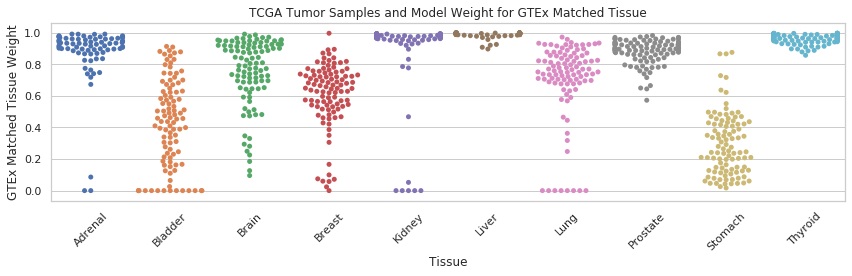

In [7]:
out_dir = '/mnt/figures/defense-figures'
w.plot_match_scatter();
plt.tight_layout()
plt.savefig(
    os.path.join(out_dir, 'TCGA-Samples-and-Model-Weight.png'), 
    dpi=300, 
    transparent=True
)

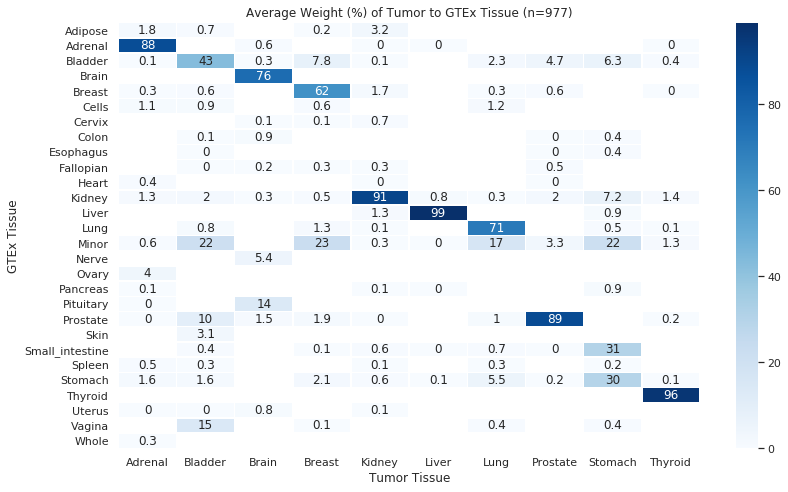

In [12]:
w.plot_perc_heatmap();
plt.tight_layout()
plt.savefig(
    os.path.join(out_dir, 'GTEx-1000-weight-heatmap.png'), 
    dpi=300, 
    transparent=True
)

Smaller version for paper

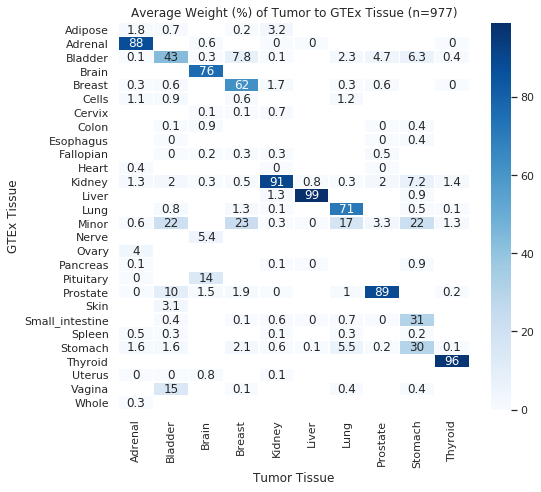

In [9]:
w.plot_perc_heatmap();
plt.tight_layout()
plt.savefig(
    os.path.join(out_dir, 'GTEx-1000-weight-heatmap-paper.png'), 
    dpi=300, 
    transparent=True
)

### Dimensionality Reduction of Low-Weight Samples

This section explores low model weight assignment to bladder and stomach samples. The subsections below show dimensionality reduction plots of samples from two tissues – bladder and stomach – that the model had difficulty assigning the correct weight to. Since the model assigns weights based on tissues that are most similar to the N-of-1 sample, it can only perform as well as the data provided. Performing PCA of bladder tumor samples alongside tissues the model assigned weight to reveal why the model has difficulty associating the normal bladder tissue in GTEx to the bladder tumor samples. GTEx possesses only 9 bladder samples and these samples cluster into two distinct groups – one near the bladder tumor samples and the other near vagina and minor salivary gland samples, which are the other two groups that were assigned a significant percentage of weight. Finally, it is apparent why the model struggled to correctly assign GTEx stomach as the primary weight for stomach cancer samples. GTEx stomach samples are split into two sub-populations and small intestine, which is proximal to and phenotypically similar to stomach tissue, clusters closely to stomach tumor samples. 

#### PCA of Bladder



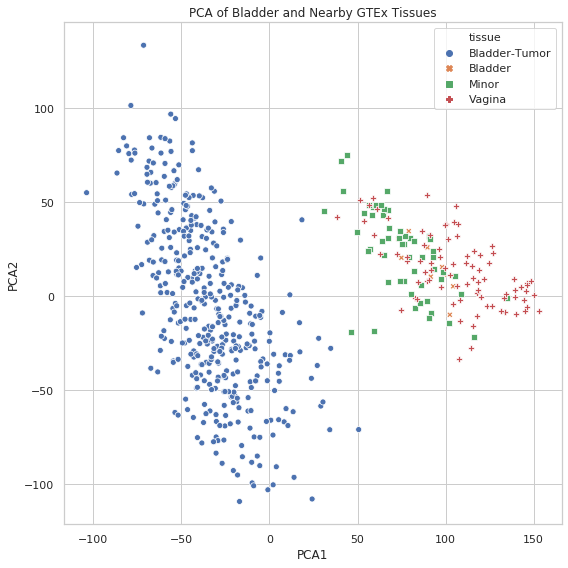

In [6]:
w.plot_pca_nearby_tissues(
    background_path='/mnt/data/outlier/gtex.hd5',
    tissues=['Bladder', 'Minor', 'Vagina'],
    tumor_tissue='Bladder'
);
plt.tight_layout()
plt.savefig(os.path.join(out_dir, 'PCA-Bladder.png'), dpi=300, transparent=True)

#### PCA of Stomach

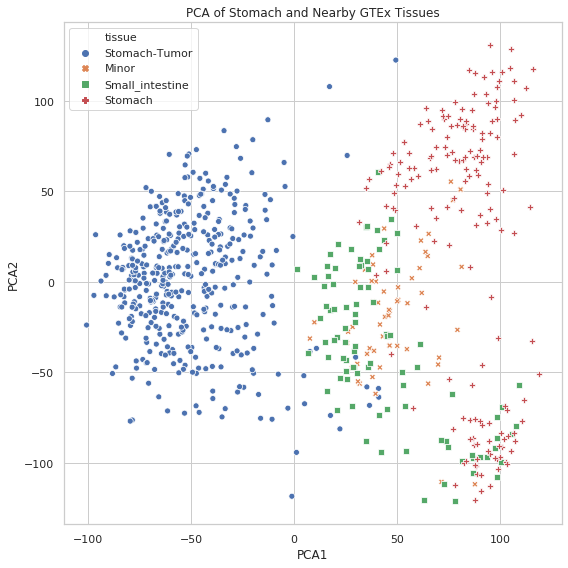

In [7]:
w.plot_pca_nearby_tissues(
    background_path='/mnt/data/outlier/gtex.hd5',
    tissues=['Stomach', 'Small_intestine', 'Minor'],
    tumor_tissue='Stomach'
);
plt.tight_layout()
plt.savefig(os.path.join(out_dir, 'PCA-Stomach.png'), dpi=300, transparent=True)